In [57]:
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
import matplotlib.gridspec as gridspec

In [58]:
df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [59]:
# lets check for null and nan values
df.isnull().any()

Pregnancies                 False
Glucose                     False
BloodPressure               False
SkinThickness               False
Insulin                     False
BMI                         False
DiabetesPedigreeFunction    False
Age                         False
Outcome                     False
dtype: bool

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


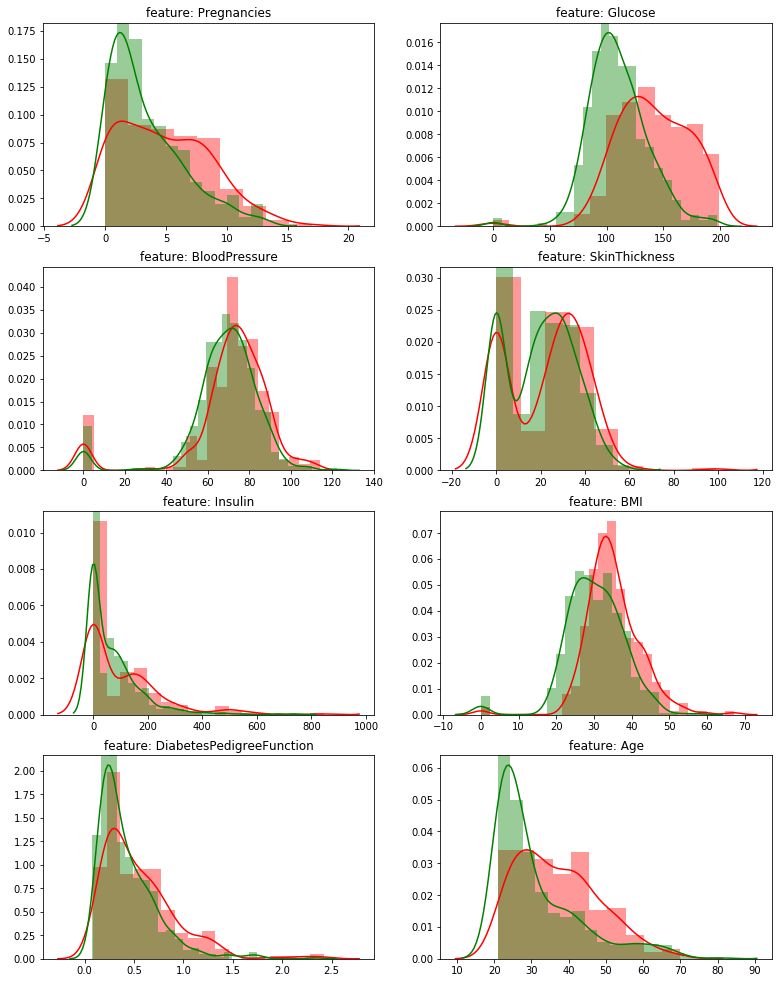

In [61]:
# lets get a sense of the values from a box plot after scaling
df2 = df.copy()
fig, ax = plt.subplots(4,2,figsize=(15,10))
for index,feature in enumerate(df2.columns[:-1]):
    row = index // 2
    col = index % 2
    ax5 = ax[row][col]
#     sns.distplot(df2[feature],ax=ax5)
    sns.distplot(df2[feature][df2.Outcome == 1], color='r',ax=ax5)
    sns.distplot(df2[feature][df2.Outcome == 0], color='g',ax=ax5)
    ax5.set_xlabel('')
    ax5.set_title('feature: ' + str(feature))
plt.subplots_adjust(bottom=0, right=0.8, top=1.3)
plt.show()

Text(0,0.5,'')

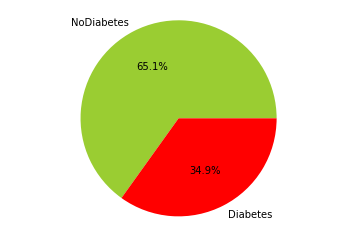

In [62]:
# lots of zero values that dont make sense. Also many of the features are skewed and not very gaussian.
# Check Outcome variable that has 0 value for no diabetes and 1 for diabetes
fig, ax = plt.subplots(1, 1)
ax.pie(df2.Outcome.value_counts(),autopct='%1.1f%%', labels=['NoDiabetes','Diabetes'], colors=['yellowgreen','r'])
plt.axis('equal')
plt.ylabel('')

We can see a clear bias here in the dataset towards people not having diabetes

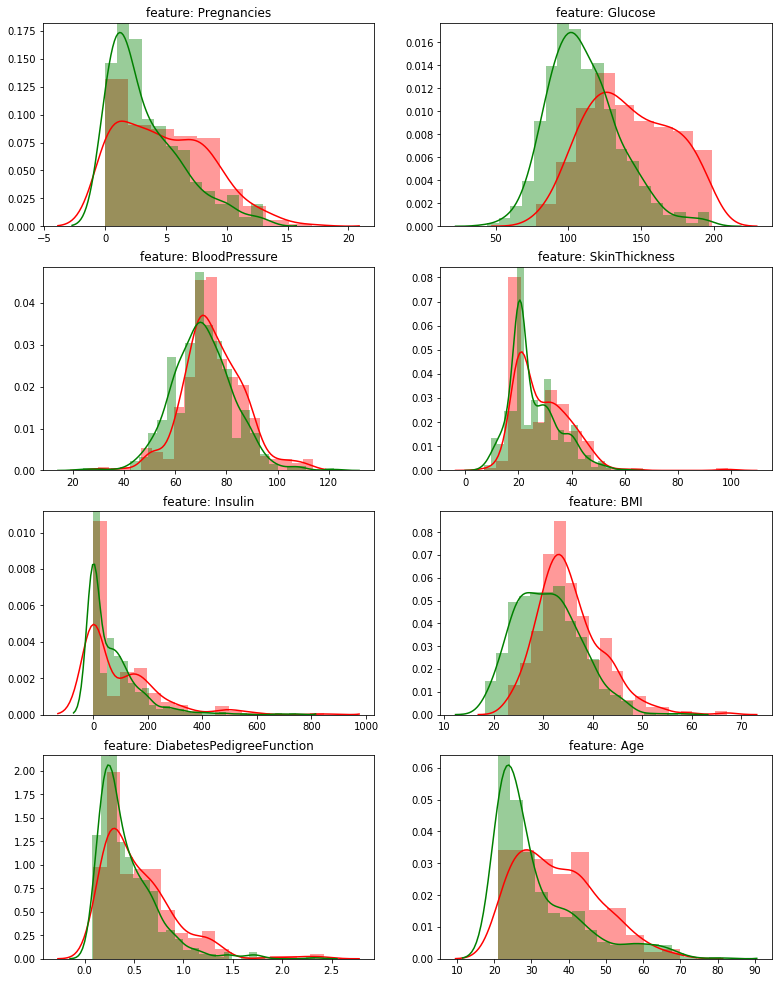

In [63]:
# So for Glucose, BloodPressure, SkinThickness and BMI lets replace the zero values by the avg value.
for feature in ['Glucose', 'BloodPressure', 'SkinThickness','BMI']:
    avg = np.mean(df2[feature])
    df2[feature] = df2[feature].apply(lambda x : avg if x == 0.0 else x )
# now lets check the changes
fig, ax = plt.subplots(4,2,figsize=(15,10))
for index,feature in enumerate(df2.columns[:-1]):
    row = index // 2
    col = index % 2
    ax5 = ax[row][col]
#     sns.distplot(df2[feature],ax=ax5)
    sns.distplot(df2[feature][df2.Outcome == 1], color='r',ax=ax5)
    sns.distplot(df2[feature][df2.Outcome == 0], color='g',ax=ax5)
    ax5.set_xlabel('')
    ax5.set_title('feature: ' + str(feature))
plt.subplots_adjust(bottom=0, right=0.8, top=1.3)
plt.show()

This seems to make at least some sense now. Some of the features seem Gaussian like BMI and blood pressure but others dont.
Lets have a look again at both the three main NB classifiers Multinomial,Gaussian,Bernoulli.

In [64]:
# create the testing dataset
X_train,X_test,y_train,y_test=train_test_split(df2[df2.columns[:-1]],df2['Outcome'],random_state=10,test_size=0.2)

0.4035087719298246

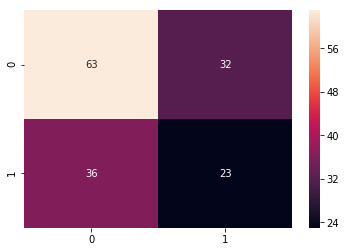

In [65]:
MultiNB = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)
MultiNB.fit(X_train,y_train)
y_pred = MultiNB.predict(X_test)
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True)
f1_score(y_test, y_pred)

0.5714285714285714

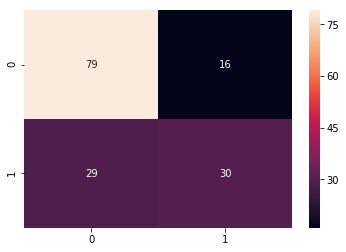

In [67]:
GaussNB = GaussianNB(priors=(0.651,0.349))
GaussNB.fit(X_train,y_train)
y2_pred = GaussNB.predict(X_test)
sns.heatmap(confusion_matrix(y_test,y2_pred), annot=True)
f1_score(y_test, y2_pred)

0.4545454545454545

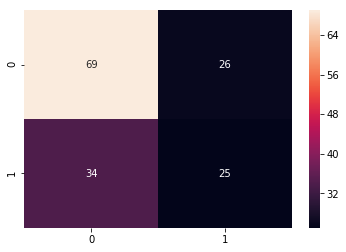

In [68]:
BernNB = BernoulliNB(alpha=1.0, binarize=0.6, fit_prior=False, class_prior=None)
BernNB.fit(X_train,y_train)
y3_pred = BernNB.predict(X_test)
sns.heatmap(confusion_matrix(y_test,y3_pred), annot=True)
f1_score(y_test, y3_pred)

Ok so the Gaussian is a clear winner. The distribution of the features though are anot always Gaussian like. Lets retry
the GaussianNB after standard scaler.

C:\Users\gr3g\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


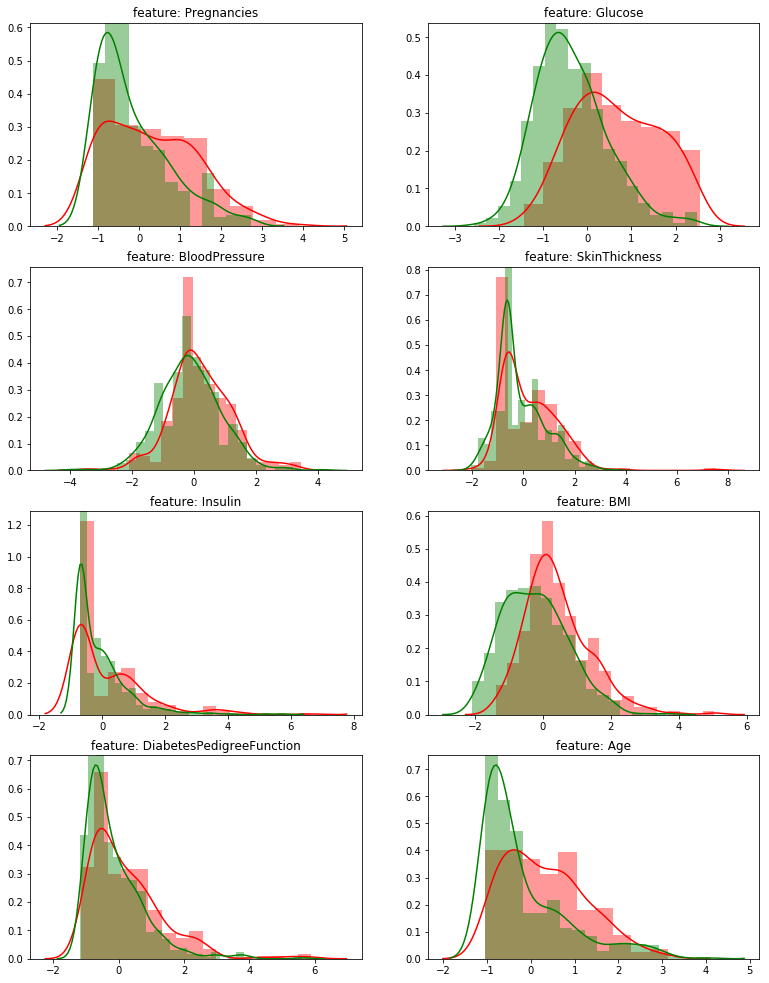

In [70]:
df3 = df2.copy()
for feature in df3.columns[:-1]:
    df3[feature] = StandardScaler().fit_transform(df3[feature].values.reshape(-1,1))
fig, ax = plt.subplots(4,2,figsize=(15,10))
for index,feature in enumerate(df3.columns[:-1]):
    row = index // 2
    col = index % 2
    ax5 = ax[row][col]
#     sns.distplot(df2[feature],ax=ax5)
    sns.distplot(df3[feature][df3.Outcome == 1], color='r',ax=ax5)
    sns.distplot(df3[feature][df3.Outcome == 0], color='g',ax=ax5)
    ax5.set_xlabel('')
    ax5.set_title('feature: ' + str(feature))
plt.subplots_adjust(bottom=0, right=0.8, top=1.3)
plt.show()

0.5833333333333334

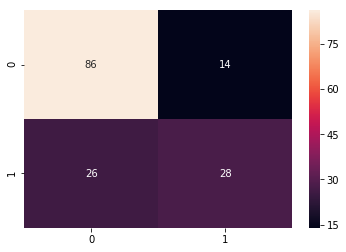

In [71]:
X2_train,X2_test,y2_train,y2_test=train_test_split(df3[df3.columns[:-1]],df3['Outcome'],random_state=11,test_size=0.2)
GaussNB = GaussianNB(priors=None)
GaussNB.fit(X2_train,y2_train)
y4_pred = GaussNB.predict(X2_test)
sns.heatmap(confusion_matrix(y2_test,y4_pred), annot=True)
f1_score(y2_test, y4_pred)